# Spectrogram Reading Seminar, Lecture 4
# Vowels
Mark Hasegawa-Johnson
February 7, 2018

## Table of Contents
1. What is a vowel made of?
2. The Peterson & Barney vowel charts
3. Decoding a vowel: example words


## 1. What is a vowel made of?
First, remember that you can download the spectrogram library from: https://courses.engr.illinois.edu/ece590sip/sp2018/sgram.py .

In [1]:
import urllib.request as request
import io
import soundfile as sf
import numpy as np
import scipy.fftpack as fft
import matplotlib.pyplot as plt
%matplotlib inline
import sgram
import math

Now let's create some synthetic vowels, so you can see what a vowel is made of.  First, let's create the excitation. 

The excitation for a vowel is caused by the vocal folds banging together, once every $T_0$ seconds.  When the vocal folds close, the air that's been flowing through them tries to keep going for a millisecond or so.  Air moving away from the closed vocal folds causes a negative pressure spike.  The air pressure immmediately above the vocal folds is therefore something like:
$$
e[n] =\left\{\begin{array}{ll}
-1 & n=kN_0,~~k=\mbox{any integer}\\
0 & \mbox{otherwise}
\end{array}\right.
$$
where $N_0$ is the pitch period in samples.  For example, with 8000 samples/second and a 100Hz pitch, we have $N_0=80$ samples.

$e[n]$ is just a buzz.  It should sound like a buzz.  That's what your voice sounds like, immediately above your glottis.

In [2]:
F_s = 8000
e = np.zeros(int(0.2*F_s)) # 200ms at 8000 samples/second
for k in range(0,20): # 20 pitch periods
    e[k*80]=-1
    
sf.write('excitation.wav',e,F_s) # save to "excitation.wav" at 8kHz sampling rate


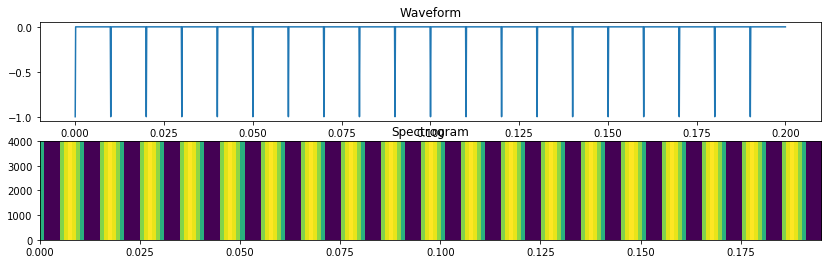

In [3]:
(S,Ext)=sgram.sgram(e,int(0.001*F_s),int(0.006*F_s),1024,F_s,4000)
plt.figure(figsize=(14,4))
plt.subplot(211)
plt.plot(np.linspace(0,0.2,len(e)),e)
plt.title('Waveform')
plt.subplot(212)
plt.imshow(S,extent=Ext,origin='lower',aspect='auto')
plt.title('Spectrogram')

Now, let's create the vowel quality.  Vowel quality is defined by the bandwidths and frequencies of the first $M$ formants (formant = resonance of the vocal tract, from larynx to lips).    In order to get reasonably natural-sounding speech, we need to synthesize $M=F_s/2$ formants, even if we really only care about the first two formants.

Suppose the formant frequencies (in Hertz) are $F_m$, and the bandwidths (in Hertz) are $B_m$.   We add each resonance to the signal by passing it through a resonator.  Let's call the input of the $m^{th}$ resonator $x_m[n]$, and its output $y_m[n]$.  In order to add four resonant frequencies, we pass the signal through four resonators in a row, such that the input of each resonator is the output of the one before:
$$
x_1[n] \rightarrow\fbox{1^{st} resonator}\rightarrow y_1[n]=x_2[n] \rightarrow\fbox{2^{nd} resonator}\rightarrow y_2[n]=x_3[n]
\rightarrow\fbox{3^{rd} resonator}\rightarrow y_3[n]=x_4[n]\rightarrow\fbox{4^{th} resonator}\rightarrow y_4[n]
$$
Each resonator adds feedback to the signal, like this:
$$
y_m[n] = x_m[n] + 2e^{-\sigma_m/2}\cos\left(\omega_m\right) y_m[n-1] - e^{-\sigma_m} y_m[n-2]
$$
where 
* $\sigma_m=\frac{2\pi B_m}{F_s}$ is the formant bandwidth expressed in units of radians/sample ($F_s$ is the sampling frequency), and 
* $\omega_m=\frac{2\pi F_m}{F_s}$ is the formant frequency expressed in units of radians/sample.

In [4]:
F = [ 500, 1500, 1900, 3500 ]
B = [ 100, 200, 300, 400 ]
F_s = 8000
omega = [ 2*math.pi*x/F_s for x in F ]
sigma = [ 2*math.pi*x/F_s for x in B ]

x = e   # start with the excitation as input to the first resonator
for m in range(0,4):
    y = np.zeros(len(x))     # create a zero-valued output
    y[0] = x[0]
    y[1] = x[1] + 2*math.exp(-sigma[m]/2)*math.cos(omega[m])*y[0]   # initialize first two samples of output
    for n in range(2,len(x)):
        y[n] = x[n] + 2*math.exp(-sigma[m]/2)*math.cos(omega[m])*y[n-1] - math.exp(-sigma[m])*y[n-2]
    x = y.copy()  # copy the output back to the input, so we're ready to go for next time
    
sf.write('vowel.wav',y,F_s)


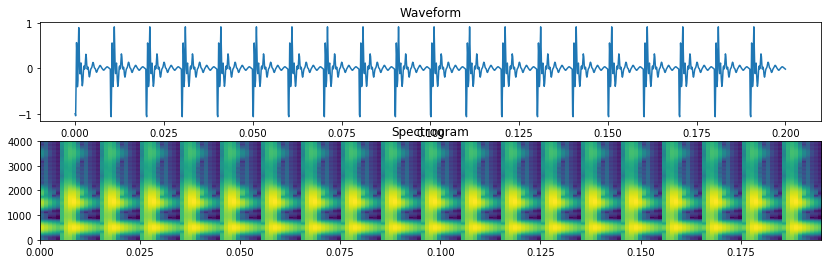

In [5]:
(S,Ext)=sgram.sgram(y,int(0.001*F_s),int(0.006*F_s),1024,F_s,4000)
plt.figure(figsize=(14,4))
plt.subplot(211)
plt.plot(np.linspace(0,0.2,len(y)),y)
plt.title('Waveform')
plt.subplot(212)
plt.imshow(S,extent=Ext,origin='lower',aspect='auto')
plt.title('Spectrogram')

Try running the code above with the following formant frequency values.  What vowels do you hear?  The first five vowels exist in Japanese and Spanish as well as American English.  The last two are kind of unique to American English.  
* F = [ 900, 1100, 2500, 3500 ]
* F = [ 300, 1900, 2500, 3500 ]
* F = [ 300, 800, 2500, 3500 ]
* F = [ 500, 1800, 2500, 3500 ]
* F = [ 500, 800, 2500, 3500 ]
* F = [ 800, 1800, 2500, 3500 ]
* F = [ 500, 1500, 1900, 3500 ]

## 2. The Peterson & Barney Vowels

In 1952, Peterson & Barney demonstrated:
1. perception of American English vowels (except /ɝ/) can be explained based on the $1^{st}$ and $2^{nd}$ formant frequencies
2. there is a region in $F_1/F_2$ space that is classified to each vowel, with a little overlap at each boundary
3. the division of $F_1/F_2$ space is different for voices of men, women, and children, but it's close enough that P&B were able to publish a single $F_1/F_2$ space for all speakers

Their article provides an astoundingly easy method for recognizing all of the vowels in a spectrogram:
1. measure $F_1$ and $F_2$
2. look up $F_1$ and $F_2$ in the corresponding figure from the Peterson & Barney article

Here's a current copy of the article on line: https://www.ling.upenn.edu/courses/Fall_2013/ling520/PetersonBarney52.pdf; the important references is Fig. 8.


Open the file shown above, and go to Figure 8.  Then download the English vowels from https://en.wikipedia.org/wiki/International_Phonetic_Alphabet.  Calculate their spectrograms, and compare the formant frequencies to the frequencies in the Peterson & Barney plot.

In [6]:
vowel_pathnames = {
        'i' : '9/91/Close_front_unrounded_vowel',
        'ɪ' : '4/4c/Near-close_near-front_unrounded_vowel',
        'e' : '6/6c/Close-mid_front_unrounded_vowel',
        'ɛ' : '7/71/Open-mid_front_unrounded_vowel',
        'æ' : 'c/c9/Near-open_front_unrounded_vowel',
        'u' : '5/5d/Close_back_rounded_vowel',
        'ʊ' : 'd/d5/Near-close_near-back_rounded_vowel',
        'o' : '8/84/Close-mid_back_rounded_vowel',
        'ʌ' : '9/92/Open-mid_back_unrounded_vowel',
        'ɑ' : 'e/e5/Open_back_unrounded_vowel',
        'ə' : 'd/d9/Mid-central_vowel',
        'ɝ' : 'e/e1/En-us-er'
}
    
vowel_waves = {}

for v_ipa,v_pathname in vowel_pathnames.items():
    v_url = 'https://upload.wikimedia.org/wikipedia/commons/{}.ogg'.format(v_pathname)
    try:
        req = request.urlopen(v_url)
    except request.HTTPError:
        print('Unable to download {}'.format(v_url))
    else:
        v_wav,v_fs = sf.read(io.BytesIO(req.read()))
        v_filename = v_pathname[5:] + '.wav'
        sf.write(v_filename,v_wav,v_fs)
        vowel_waves[v_ipa] = v_wav

print('Donwnloaded these phones: {}'.format(vowel_waves.keys()))

Donwnloaded these phones: dict_keys(['i', 'ɪ', 'e', 'ɛ', 'æ', 'u', 'ʊ', 'o', 'ʌ', 'ɑ', 'ə', 'ɝ'])


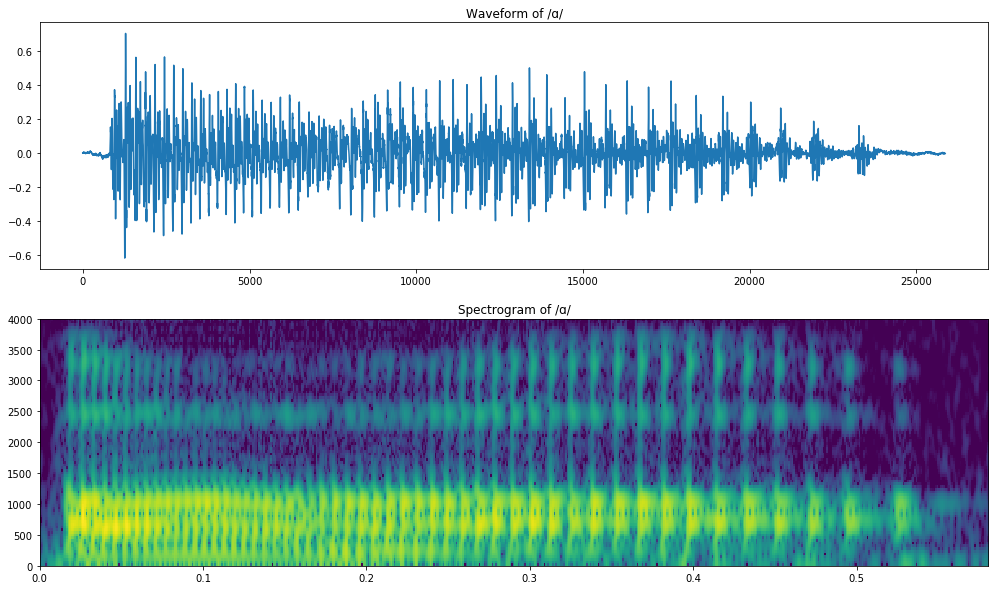

In [19]:
vowel = 'ɑ'
(S,Ext)=sgram.sgram(vowel_waves[vowel], int(0.001*v_fs), int(0.006*v_fs), 1024, v_fs, 4000)
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(vowel_waves[vowel])
plt.title('Waveform of /{}/'.format(vowel))
plt.subplot(212)
plt.imshow(S,origin='lower',extent=Ext,aspect='auto')
plt.title('Spectrogram of /{}/'.format(vowel))

## 3. Decoding a spectrogram: example words

Let's try it!  Download spectrograms of some interesting words.  Try measuring the formant frequencies $F_1$ and $F_2$ of each vowel, and comparing them against the Peterson and Barney chart.

In [16]:
x_url = 'https://upload.wikimedia.org/wikipedia/commons/e/e2/En-us-remark.ogg'
try:
    req = request.urlopen(x_url)
except request.HTTPError:
    print('Unable to download {}'.format(x_url))
else:
    x_wav,x_fs = sf.read(io.BytesIO(req.read()))
    sf.write('word.wav',x_wav,x_fs)

print('Donwnloaded  {}'.format(x_url))

Donwnloaded  https://upload.wikimedia.org/wikipedia/commons/e/e2/En-us-remark.ogg


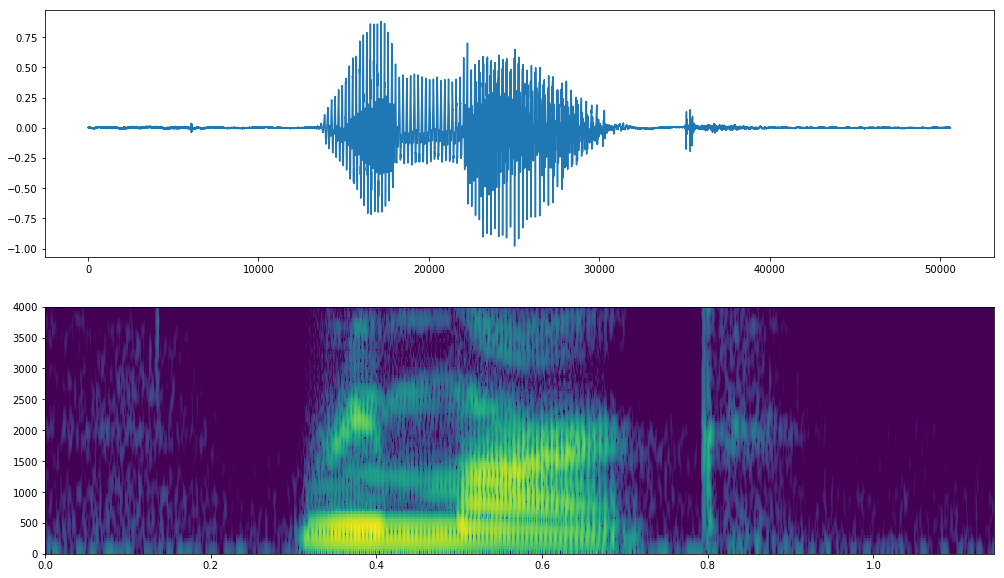

In [18]:
(x_sgram,x_extent)=sgram.sgram(x_wav, int(0.001*x_fs), int(0.006*x_fs), 1024, x_fs, 4000)
plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(x_wav)
plt.subplot(212)
plt.imshow(x_sgram,origin='lower',extent=x_extent,aspect='auto')

Try downloading the following words from wiktionary, and looking up their vowel formant frequencies in P&B:
* 4/40/En-us-reboot
* b/b6/En-us-fantastic
* b/b9/En-us-above --- notice that the vowels /ə/ and /ɝ/ have exactly the same $F_1$ and $F_2$, they are only distinguished by $F_3$, that's why Peterson & Barney don't separately list /ə/.
* e/e2/En-us-remark
* e/ee/En-us-about, f/f4/En-us-bite, 7/7f/En-us-boy -- these contain the diphthongs /æu,ɑi,oi/, each diphthong is actually two vowels in sequence